# Procesado de datos

Una vez que se ha realizado el preprocesamiento de los datos, el DataFrame que se dispone está más limpio 
para poder realizar una selección de variables y arreglar los valores nulos de las variables numéricas.

## Carga de librerías

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import utilidades
from list_utils import column_diff_lc, get_names_start_with, list_high_correlated_columns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

In [2]:
pd.set_option('display.max_columns', None)

## Carga del conjunto de entrenamiento

In [3]:
df = pd.read_csv('../data/generated/pp_train_with_categorias.csv')
df = df.set_index('id')
df.head()

host_response_rate  host_acceptance_rate  host_listings_count  \
id                                                                        
39069298                 0.7                  0.67                 16.0   
17473772                 0.9                  1.00                  1.0   
19938242                 1.0                  0.90                205.0   
928607                   1.0                  1.00                 28.0   
43882655                 1.0                  0.91                  9.0   

          host_total_listings_count  host_has_profile_pic  \
id                                                          
39069298                       16.0                     1   
17473772                        1.0                     1   
19938242                      205.0                     1   
928607                         28.0                     1   
43882655                        9.0                     1   

          host_identity_verified  latitude  longitude  accommodates  \
id                                                                    
39069298                       1  39.36348    2.94798             6   
17473772                       0  39.54960    2.59613             1   
19938242                       1  39.57886    3.36663             6   
928607                         1  39.73556    3.22643             6   
43882655                       1  39.34056    3.04821             8   

          bathrooms_text  bedrooms  beds  amenities  minimum_nights  \
id                                                                    
39069298             3.0       3.0   5.0         11               6   
17473772             1.0       1.0   1.0         17               3   
19938242             2.0       3.0   6.0         36               7   
928607               2.0       3.0   5.0         34               5   
43882655             3.0       4.0   4.0         23               5   

          maximum_nights  minimum_minimum_nights  maximum_minimum_nights  \
id                                                                         
39069298            1125                       6                       6   
17473772              60                       3                       3   
19938242            1125                       7                       7   
928607                60                       5                       5   
43882655             365                       5                       5   

          minimum_maximum_nights  maximum_maximum_nights  \
id                                                         
39069298                    1125                    1125   
17473772                    1125                    1125   
19938242                    1125                    1125   
928607                        30                      60   
43882655                    1125                    1125   

          minimum_nights_avg_ntm  maximum_nights_avg_ntm  has_availability  \
id                                                                           
39069298                     6.0                  1125.0                 1   
17473772                     3.0                  1125.0                 1   
19938242                     7.0                  1125.0                 1   
928607                       5.0                    30.1                 1   
43882655                     5.0                  1125.0                 1   

          availability_30  availability_60  availability_90  availability_365  \
id                                                                              
39069298               23               53               83                83   
17473772               19               49               79                79   
19938242               30               48               48               211   
928607                  4               31               61               307   
43882655               29               59               89              

## Procesamiento

Una vez que se tiene el conjunto de datos cargado, se seleccionarán solamente parte de las columnas que se
utilizarán para trabajar.
También se mantendrán las variables que son categóricas.
La lista de columnas deseadas son las siguientes, incluyendo las que están en OHE (One Hot Encoding):

* latitude
* longitude
* accommodates
* bathrooms_text
* beedrooms
* beds
* amenities
* minimum_nights
* maximum_nights
* license
* availability_365
* price (Columna objetivo)
* neighbourhood_cleansed
* property_type
* room_type
* amenities_

Estas columnas se han seleccionado porque hacen referencia, principalmente, a características de un apartamento y no se
incluyen variables que podrían ser más subjetivas como el ratio de comentarios o las que hacen referencia al host.

In [4]:
df.groupby('has_availability')[['has_availability']].count()

has_availability
has_availability                  
0                                1
1                            12683

Como se aprecia, la columna ```has_availability``` no aporta mucha información, ya que todos los apartamentos tienen
disponibilidad, exceptuando solamente 1 apartamento que no tiene, por lo tanto, no se seleccionará, aunque fuera una
candidata, por el contenido que podría aportar.

Como hay columnas que están codificadas en OHE, no se puede realizar una selección de columnas directamente.
Por ejemplo, para seleccionar la columna que antiguamente hacia referencia a neighbourhood_cleansed, se debería
seleccionar todas sus subcolumnas generadas por la transformación del OHE, por lo tanto, se realizará una
búsqueda por los nombres de las columnas del dataframe para obtener los nombres que corresponden a la columna,
ya que al haber realizado el OHE con Pandas se dispone de un prefijo en la columna.

Después se procederá a realizar una unión de listas y así tener una lista con las variables que se desean.

In [5]:
nc_names = get_names_start_with(df, 'neighbourhood_cleansed')
pt_names = get_names_start_with(df, 'property_type')
rt_names = get_names_start_with(df, 'room_type')
at_names = get_names_start_with(df, 'amenities_')

In [6]:
columnas_deseadas = ['latitude', 'longitude', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 
                     'amenities', 'minimum_nights', 'maximum_nights', 'license', 'availability_365', 'price']

In [7]:
todas_columnas_deseadas = [*columnas_deseadas, *nc_names, *pt_names, *rt_names, *at_names]

In [8]:
dc = utilidades.SelectColumns(todas_columnas_deseadas)
df_2 = dc.fit_transform(df)

Después de realizar la transformación se comprueba si hay filas que contienen alguna variable sin 
información. Esta comprobación se realiza con las variables que no son OHE, ya que en el apartado
de Preprocesamiento, se garantizó que las OHE tengan todas información.

In [9]:
df_2.iloc[:,0:len(columnas_deseadas)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12684 entries, 39069298 to 13889912
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   latitude          12684 non-null  float64
 1   longitude         12684 non-null  float64
 2   accommodates      12684 non-null  int64  
 3   bathrooms_text    12684 non-null  float64
 4   bedrooms          12508 non-null  float64
 5   beds              12610 non-null  float64
 6   amenities         12684 non-null  int64  
 7   minimum_nights    12684 non-null  int64  
 8   maximum_nights    12684 non-null  int64  
 9   license           12684 non-null  int64  
 10  availability_365  12684 non-null  int64  
 11  price             12684 non-null  float64
dtypes: float64(6), int64(6)
memory usage: 1.3 MB


Una vez que se dispone de las columnas que son relevantes, se prepara el sistema para realizar la división en train
y test.

In [10]:
dropPrice = utilidades.DropColumns(['price'])
selectPrice = utilidades.SelectColumns(['price'])
X = dropPrice.fit_transform(df_2)
y = selectPrice.fit_transform(df_2)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

In [12]:
X_train.head()

latitude  longitude  accommodates  bathrooms_text  bedrooms  beds  \
id                                                                            
29117332  39.50326    2.91976             2             1.0       1.0   2.0   
40105087  39.37370    3.23648             8             4.0       3.0   4.0   
34857910  39.50690    2.75216             2             1.0       1.0   1.0   
29655090  39.50117    2.47868            10             5.0       5.0   5.0   
38860987  39.36308    2.95336             4             2.0       2.0   3.0   

          amenities  minimum_nights  maximum_nights  license  \
id                                                             
29117332         25               4            1125        0   
40105087          9               7              21        1   
34857910         28               1              30        0   
29655090         13               1            1125        0   
38860987         15               3            1125        0   

          availability_365  neighbourhood_cleansed_Alaró  \
id                                                         
29117332               365                             0   
40105087               187                             0   
34857910                10                             0   
29655090               363                             0   
38860987               256                             0   

          neighbourhood_cleansed_Alcúdia  neighbourhood_cleansed_Algaida  \
id                                                                         
29117332                               0                               0   
40105087                               0                               0   
34857910                               0                               0   
29655090                               0                               0   
38860987                               0                               0   

          neighbourhood_cleansed_Andratx  neighbourhood_cleansed_Ariany  \
id                                                                        
29117332                               0                              0   
40105087                               0                              0   
34857910                               0                              0   
29655090                               0                              0   
38860987                               0                              0   

          neighbourhood_cleansed_Artà  neighbourhood_cleansed_Banyalbufar  \
id                                                                          
29117332                            0                                   0   
40105087                            0                                   0   
34857910                            0                                   0   
29655090                            0                                   0   
38860987                            0                                   0   

          neighbourhood_cleansed_Binissalem  neighbourhood_cleansed_Bunyola  \
id                                                                            
29117332                                  0                               0   
40105087                                  0                               0   
34857910                                  0                               0   
29655090                                  0                               0   
38860987                                  0                               0   

          neighbourhood_cleansed_Búger  neighbourhood_cleansed_Calvià  \
id                                                                      
29117332                             0                              0   
40105087                             0                              0   
34857910                             0                              0   
29655090                             0                              

In [13]:
X_train.describe()

latitude    longitude  accommodates  bathrooms_text     bedrooms  \
count  9513.000000  9513.000000   9513.000000     9513.000000  9389.000000   
mean     39.662422     3.001911      5.969831        2.328550     3.004154   
std       0.165891     0.242672      2.721290        1.358568     1.505098   
min      39.301970     2.346500      1.000000        0.000000     1.000000   
25%      39.550150     2.853330      4.000000        1.000000     2.000000   
50%      39.682940     3.052680      6.000000        2.000000     3.000000   
75%      39.804110     3.147380      8.000000        3.000000     4.000000   
max      39.928500     3.473150     16.000000       19.000000    33.000000   

              beds    amenities  minimum_nights  maximum_nights     license  \
count  9456.000000  9513.000000     9513.000000     9513.000000  9513.00000   
mean      4.438769    24.322086        4.007674      880.940187     0.67371   
std       2.587538     9.636416        6.729659      439.721280     0.46888   
min       0.000000     1.000000        1.000000        1.000000     0.00000   
25%       3.000000    17.000000        1.000000     1124.000000     0.00000   
50%       4.000000    24.000000        3.000000     1125.000000     1.00000   
75%       6.000000    31.000000        6.000000     1125.000000     1.00000   
max      50.000000    65.000000      365.000000     1125.000000     1.00000   

       availability_365  neighbourhood_cleansed_Alaró  \
count       9513.000000                   9513.000000   
mean         232.605277                      0.006623   
std          123.959480                      0.081113   
min            0.000000                      0.000000   
25%          144.000000                      0.000000   
50%          262.000000                      0.000000   
75%          353.000000                      0.000000   
max          365.000000                      1.000000   

       neighbourhood_cleansed_Alcúdia  neighbourhood_cleansed_Algaida  \
count                     9513.000000                     9513.000000   
mean                         0.104383                        0.007779   
std                          0.305773                        0.087859   
min                          0.000000                        0.000000   
25%                          0.000000                        0.000000   
50%                          0.000000                        0.000000   
75%                          0.000000                        0.000000   
max                          1.000000                        1.000000   

       neighbourhood_cleansed_Andratx  neighbourhood_cleansed_Ariany  \
count                     9513.000000                    9513.000000   
mean                         0.015242                       0.004730   
std                          0.122522                       0.068618   
min                          0.000000                       0.000000   
25%                          0.000000                       0.000000   
50%                          0.000000                       0.000000   
75%                          0.000000                       0.000000   
max                          1.000000                       1.000000   

       neighbourhood_cleansed_Artà  neighbourhood_cleansed_Banyalbufar  \
count                  9513.000000                         9513.000000   
mean                      0.022811                            0.002628   
std                       0.149308                            0.051199   
min                       0.000000                            0.000000   
25%                       0.000000                            0.000000   
50%                       0.000000                            0.000000   
75%                       0.000000                            0.000000   
max                       1.000000                            1.000000   

       neighbourhood_cleansed_Binissalem  neighbourhood_cleansed_Bunyola  \
count                        95

Aunque el proceso de análisis de valores anómalos se plantea en los siguientes apartados, se realizará una consulta en
el dataset sin transformar, ya que se pierde el valor del ID al realizar las transformaciones, y así quedan
reflejados que los valores se deberán eliminar son los mismos.

In [14]:
X_train[X_train['beds']>30]

latitude  longitude  accommodates  bathrooms_text  bedrooms  beds  \
id                                                                            
14181351  39.67880    2.90338            16            13.0      16.0  32.0   
43779092  39.55898    2.62370            16            10.0       2.0  37.0   
32133479  39.86818    3.02310            16             2.0      12.0  50.0   

          amenities  minimum_nights  maximum_nights  license  \
id                                                             
14181351         16               7              59        1   
43779092         13               1             365        0   
32133479          9               1            1125        0   

          availability_365  neighbourhood_cleansed_Alaró  \
id                                                         
14181351               208                             0   
43779092               134                             0   
32133479               365                             0   

          neighbourhood_cleansed_Alcúdia  neighbourhood_cleansed_Algaida  \
id                                                                         
14181351                               0                               0   
43779092                               0                               0   
32133479                               0                               0   

          neighbourhood_cleansed_Andratx  neighbourhood_cleansed_Ariany  \
id                                                                        
14181351                               0                              0   
43779092                               0                              0   
32133479                               0                              0   

          neighbourhood_cleansed_Artà  neighbourhood_cleansed_Banyalbufar  \
id                                                                          
14181351                            0                                   0   
43779092                            0                                   0   
32133479                            0                                   0   

          neighbourhood_cleansed_Binissalem  neighbourhood_cleansed_Bunyola  \
id                                                                            
14181351                                  0                               0   
43779092                                  0                               0   
32133479                                  0                               0   

          neighbourhood_cleansed_Búger  neighbourhood_cleansed_Calvià  \
id                                                                      
14181351                             0                              0   
43779092                             0                              0   
32133479                             0                              0   

          neighbourhood_cleansed_Campanet  neighbourhood_cleansed_Campos  \
id                                                                         
14181351                                0                              0   
43779092                                0                              0   
32133479                                0                              0   

          neighbourhood_cleansed_Capdepera  neighbourhood_cleansed_Consell  \
id                                                                           
14181351                                 0                               0   
43779092                                 0                               0   
32133479                                 0                               0   

          neighbourhood_cleansed_Costitx  neighbourhood_cleansed_Deyá  \
id                                                                      
14181351                               0                            0   
43779092                               0                            0   
32133479               

In [15]:
X_train[X_train['bedrooms']>30]

latitude  longitude  accommodates  bathrooms_text  bedrooms  beds  \
id                                                                            
30261754  39.83707     3.1144             4             1.0      33.0   4.0   

          amenities  minimum_nights  maximum_nights  license  \
id                                                             
30261754         16               1            1125        1   

          availability_365  neighbourhood_cleansed_Alaró  \
id                                                         
30261754               245                             0   

          neighbourhood_cleansed_Alcúdia  neighbourhood_cleansed_Algaida  \
id                                                                         
30261754                               1                               0   

          neighbourhood_cleansed_Andratx  neighbourhood_cleansed_Ariany  \
id                                                                        
30261754                               0                              0   

          neighbourhood_cleansed_Artà  neighbourhood_cleansed_Banyalbufar  \
id                                                                          
30261754                            0                                   0   

          neighbourhood_cleansed_Binissalem  neighbourhood_cleansed_Bunyola  \
id                                                                            
30261754                                  0                               0   

          neighbourhood_cleansed_Búger  neighbourhood_cleansed_Calvià  \
id                                                                      
30261754                             0                              0   

          neighbourhood_cleansed_Campanet  neighbourhood_cleansed_Campos  \
id                                                                         
30261754                                0                              0   

          neighbourhood_cleansed_Capdepera  neighbourhood_cleansed_Consell  \
id                                                                           
30261754                                 0                               0   

          neighbourhood_cleansed_Costitx  neighbourhood_cleansed_Deyá  \
id                                                                      
30261754                               0                            0   

          neighbourhood_cleansed_Escorca  neighbourhood_cleansed_Esporles  \
id                                                                          
30261754                               0                                0   

          neighbourhood_cleansed_Estellencs  neighbourhood_cleansed_Felanitx  \
id                                                                             
30261754                                  0                                0   

          neighbourhood_cleansed_Fornalutx  neighbourhood_cleansed_Inca  \
id                                                                        
30261754                                 0                            0   

          neighbourhood_cleansed_Lloret de Vistalegre  \
id                                                      
30261754                                            0   

          neighbourhood_cleansed_Lloseta  neighbourhood_cleansed_Llubí  \
id                                                                       
30261754                               0                             0   

          neighbourhood_cleansed_Llucmajor  neighbourhood_cleansed_Manacor  \
id                                                                           
30261754                                 0                               0   

          neighbourhood_cleansed_Mancor de la Vall  \
id                                                   
30261754                                         0   

          neighbourhood_cleansed_Maria de la Salut  \
id                     

### Imputer Pipeline

De las columnas que no son OHE, solamente hay 2 numéricas que requieran realizar
una imputación de valores por media.

In [16]:
select_col_step = ('seleccionar_dormitorios', utilidades.SelectColumns(['bedrooms', 'beds']))
simple_imputer_step = ('fill_na', SimpleImputer(strategy='mean'))
imputer_steps = [select_col_step, simple_imputer_step]
imputer_pipe = Pipeline(imputer_steps)

### Scaler Pipeline
La variable ```maximum_nights``` difiere bastante de los valores que tienen el resto de variables en escala,
por lo tanto, se realizará una adaptación de los datos haciendo uso del ```MinMaxScaler```, es decir
realizar un escalado utilizando valores máximos y mínimos.

In [17]:
select_col_scaler_step = ('select_m_nights', utilidades.SelectColumns(['maximum_nights', 'availability_365']))
min_max_scaler_step = ('min_max_scaler', MinMaxScaler())
scaler_steps = [select_col_scaler_step, min_max_scaler_step]
scaler_pipe = Pipeline(scaler_steps)

### Get other variables

In [18]:
columnas_modificadas = ['bedrooms', 'beds', 'maximum_nights', 'availability_365']
resto_columnas = column_diff_lc(X_train.columns.values, columnas_modificadas)

In [19]:
select_col_other_step = ('select rest of variables', utilidades.SelectColumns(resto_columnas))
get_other_steps = [select_col_other_step]
get_other_pipe = Pipeline(get_other_steps)

### Unión de los Pipeline

En este caso se unen todas las transformaciones para generar el ```Pipeline``` que se encargará
de ejecutarlas. Como se utilizan algunas funciones de ```sklearn```, después de ejecutar
el Pipeline, se deberá volver a asignar los nombres de las variables con el mismo orden
que se han ejecutado los transformadores del ```Pipeline```.

In [20]:
transformer_list = [('imp_pipe', imputer_pipe),
                    ('sca_pipe', scaler_pipe),
                    ('rest_pipe', get_other_pipe)]
full_pipe = FeatureUnion(transformer_list=transformer_list)

In [21]:
X_train_t = pd.DataFrame(full_pipe.fit_transform(X_train))

In [22]:
X_train_t.columns = [*columnas_modificadas, *resto_columnas]

In [23]:
X_train_t.head()

bedrooms  beds  maximum_nights  availability_365  latitude  longitude  \
0       1.0   2.0        1.000000          1.000000  39.50326    2.91976   
1       3.0   4.0        0.017794          0.512329  39.37370    3.23648   
2       1.0   1.0        0.025801          0.027397  39.50690    2.75216   
3       5.0   5.0        1.000000          0.994521  39.50117    2.47868   
4       2.0   3.0        1.000000          0.701370  39.36308    2.95336   

   accommodates  bathrooms_text  amenities  minimum_nights  license  \
0           2.0             1.0       25.0             4.0      0.0   
1           8.0             4.0        9.0             7.0      1.0   
2           2.0             1.0       28.0             1.0      0.0   
3          10.0             5.0       13.0             1.0      0.0   
4           4.0             2.0       15.0             3.0      0.0   

   neighbourhood_cleansed_Alaró  neighbourhood_cleansed_Alcúdia  \
0                           0.0                             0.0   
1                           0.0                             0.0   
2                           0.0                             0.0   
3                           0.0                             0.0   
4                           0.0                             0.0   

   neighbourhood_cleansed_Algaida  neighbourhood_cleansed_Andratx  \
0                             0.0                             0.0   
1                             0.0                             0.0   
2                             0.0                             0.0   
3                             0.0                             0.0   
4                             0.0                             0.0   

   neighbourhood_cleansed_Ariany  neighbourhood_cleansed_Artà  \
0                            0.0                          0.0   
1                            0.0                          0.0   
2                            0.0                          0.0   
3                            0.0                          0.0   
4                            0.0                          0.0   

   neighbourhood_cleansed_Banyalbufar  neighbourhood_cleansed_Binissalem  \
0                                 0.0                                0.0   
1                                 0.0                                0.0   
2                                 0.0                                0.0   
3                                 0.0                                0.0   
4                                 0.0                                0.0   

   neighbourhood_cleansed_Bunyola  neighbourhood_cleansed_Búger  \
0                             0.0                           0.0   
1                             0.0                           0.0   
2                             0.0                           0.0   
3                             0.0                           0.0   
4                             0.0                           0.0   

   neighbourhood_cleansed_Calvià  neighbourhood_cleansed_Campanet  \
0                            0.0                              0.0   
1                            0.0                              0.0   
2                            0.0                              0.0   
3                            1.0                              0.0   
4                            0.0                              0.0   

   neighbourhood_cleansed_Campos  neighbourhood_cleansed_Capdepera  \
0                            0.0                               0.0   
1                            0.0                               0.0   
2                            0.0                               0.0   
3                            0.0                               0.0   
4                            1.0                               0.0   

   neighbourhood_cleansed_Consell  neighbourhood_cleansed_Costitx  \
0                             0.0                             0.0   
1                             0.0                             0.0   
2      

Una vez realizadas todas las transformaciones (escalado de algunas variables + la imputación de nulos), el siguiente
paso a realizar es el análisis de la correlación entre variables.
Si una variable está muy correlacionada, puede suponer un problema para un clasificador,
ya que tiene 2 variables que le aportan aproximadamente la misma información.

Para este estudio se considerará que una variable está correlacionada con otra si su valor absoluto es mayor a 0.85,
un valor muy cercano a 1 pero dando cierto margen de flexibilidad.

In [24]:
high_correlated_columns = list_high_correlated_columns(X_train_t, 0.85)
high_correlated_columns

['accommodates',
 'room_type_Private room',
 'amenities_refrigerator',
 'amenities_terrace',
 'amenities_heated infinity pool',
 'amenities_gated community',
 'amenities_smart home technology',
 'amenities_gas fireplace',
 'amenities_parasols',
 'amenities_view tower',
 'amenities_video games',
 'amenities_saltwater pool',
 'amenities_game room',
 'amenities_wine bar',
 'amenities_dual vanity',
 'amenities_stand alone bathtub',
 'amenities_pizza oven',
 'amenities_stand alone rain shower',
 'amenities_stand alone shower',
 'amenities_shower bathtub combo',
 'amenities_water filtration system',
 'amenities_tennis court',
 'amenities_courtyard',
 'amenities_mountain view']

Una vez que se dispone de las variables altamente correlacionadas se procede a eliminar las columnas.

In [25]:
dhcc = utilidades.DropColumns(high_correlated_columns)
X_train_t2 = dhcc.fit_transform(X_train_t)

Una vez eliminadas, se puede realizar un ```describe``` para detectar valores anómalos dentro de las variables

In [26]:
X_train_t2.describe()

bedrooms         beds  maximum_nights  availability_365  \
count  9513.000000  9513.000000     9513.000000       9513.000000   
mean      3.004154     4.438769        0.782865          0.637275   
std       1.495256     2.579773        0.391211          0.339615   
min       1.000000     0.000000        0.000000          0.000000   
25%       2.000000     3.000000        0.999110          0.394521   
50%       3.000000     4.000000        1.000000          0.717808   
75%       4.000000     6.000000        1.000000          0.967123   
max      33.000000    50.000000        1.000000          1.000000   

          latitude    longitude  bathrooms_text    amenities  minimum_nights  \
count  9513.000000  9513.000000     9513.000000  9513.000000     9513.000000   
mean     39.662422     3.001911        2.328550    24.322086        4.007674   
std       0.165891     0.242672        1.358568     9.636416        6.729659   
min      39.301970     2.346500        0.000000     1.000000        1.000000   
25%      39.550150     2.853330        1.000000    17.000000        1.000000   
50%      39.682940     3.052680        2.000000    24.000000        3.000000   
75%      39.804110     3.147380        3.000000    31.000000        6.000000   
max      39.928500     3.473150       19.000000    65.000000      365.000000   

          license  neighbourhood_cleansed_Alaró  \
count  9513.00000                   9513.000000   
mean      0.67371                      0.006623   
std       0.46888                      0.081113   
min       0.00000                      0.000000   
25%       0.00000                      0.000000   
50%       1.00000                      0.000000   
75%       1.00000                      0.000000   
max       1.00000                      1.000000   

       neighbourhood_cleansed_Alcúdia  neighbourhood_cleansed_Algaida  \
count                     9513.000000                     9513.000000   
mean                         0.104383                        0.007779   
std                          0.305773                        0.087859   
min                          0.000000                        0.000000   
25%                          0.000000                        0.000000   
50%                          0.000000                        0.000000   
75%                          0.000000                        0.000000   
max                          1.000000                        1.000000   

       neighbourhood_cleansed_Andratx  neighbourhood_cleansed_Ariany  \
count                     9513.000000                    9513.000000   
mean                         0.015242                       0.004730   
std                          0.122522                       0.068618   
min                          0.000000                       0.000000   
25%                          0.000000                       0.000000   
50%                          0.000000                       0.000000   
75%                          0.000000                       0.000000   
max                          1.000000                       1.000000   

       neighbourhood_cleansed_Artà  neighbourhood_cleansed_Banyalbufar  \
count                  9513.000000                         9513.000000   
mean                      0.022811                            0.002628   
std                       0.149308                            0.051199   
min                       0.000000                            0.000000   
25%                       0.000000                            0.000000   
50%                       0.000000                            0.000000   
75%                       0.000000                            0.000000   
max                       1.000000                            1.000000   

       neighbourhood_cleansed_Binissalem  neighbourhood_cleansed_Bunyola  \
count                        9513.000000                     9513.000000   
mean                            0.005676                        0.005256   
std  

En este caso se detectan 2 variables que tienen valores anómalos, ya que difícilmente una propiedad tiene 33
habitaciones destinadas solamente a dormitorios y también tener más de 37 camas en 2 habitaciones.

In [27]:
X_train_t2[X_train_t2['bedrooms']>30]

bedrooms  beds  maximum_nights  availability_365  latitude  longitude  \
1598      33.0   4.0             1.0          0.671233  39.83707     3.1144   

      bathrooms_text  amenities  minimum_nights  license  \
1598             1.0       16.0             1.0      1.0   

      neighbourhood_cleansed_Alaró  neighbourhood_cleansed_Alcúdia  \
1598                           0.0                             1.0   

      neighbourhood_cleansed_Algaida  neighbourhood_cleansed_Andratx  \
1598                             0.0                             0.0   

      neighbourhood_cleansed_Ariany  neighbourhood_cleansed_Artà  \
1598                            0.0                          0.0   

      neighbourhood_cleansed_Banyalbufar  neighbourhood_cleansed_Binissalem  \
1598                                 0.0                                0.0   

      neighbourhood_cleansed_Bunyola  neighbourhood_cleansed_Búger  \
1598                             0.0                           0.0   

      neighbourhood_cleansed_Calvià  neighbourhood_cleansed_Campanet  \
1598                            0.0                              0.0   

      neighbourhood_cleansed_Campos  neighbourhood_cleansed_Capdepera  \
1598                            0.0                               0.0   

      neighbourhood_cleansed_Consell  neighbourhood_cleansed_Costitx  \
1598                             0.0                             0.0   

      neighbourhood_cleansed_Deyá  neighbourhood_cleansed_Escorca  \
1598                          0.0                             0.0   

      neighbourhood_cleansed_Esporles  neighbourhood_cleansed_Estellencs  \
1598                              0.0                                0.0   

      neighbourhood_cleansed_Felanitx  neighbourhood_cleansed_Fornalutx  \
1598                              0.0                               0.0   

      neighbourhood_cleansed_Inca  \
1598                          0.0   

      neighbourhood_cleansed_Lloret de Vistalegre  \
1598                                          0.0   

      neighbourhood_cleansed_Lloseta  neighbourhood_cleansed_Llubí  \
1598                             0.0                           0.0   

      neighbourhood_cleansed_Llucmajor  neighbourhood_cleansed_Manacor  \
1598                               0.0                             0.0   

      neighbourhood_cleansed_Mancor de la Vall  \
1598                                       0.0   

      neighbourhood_cleansed_Maria de la Salut  \
1598                                       0.0   

      neighbourhood_cleansed_Marratxí  neighbourhood_cleansed_Montuïri  \
1598                              0.0                              0.0   

      neighbourhood_cleansed_Muro  neighbourhood_cleansed_Palma de Mallorca  \
1598                          0.0                                       0.0   

      neighbourhood_cleansed_Petra  neighbourhood_cleansed_Pollença  \
1598                           0.0                              0.0   

      neighbourhood_cleansed_Porreres  neighbourhood_cleansed_Puigpunyent  \
1598                              0.0                                 0.0   

      neighbourhood_cleansed_Sa Pobla  neighbourhood_cleansed_Sant Joan  \
1598                              0.0                               0.0   

      neighbourhood_cleansed_Sant Llorenç des Cardassar  \
1598                                                0.0   

      neighbourhood_cleansed_Santa Eugènia  \
1598                                   0.0   

      neighbourhood_cleansed_Santa Margalida  \
1598                                     0.0   

      neighbourhood_cleansed_Santa María del Camí  \
1598                                          0.0   

      neighbourhood_cleansed_Santanyí  neighbourhood_cleansed_Selva  \
1598                              0.0                           0.0   

      neighbourhood_cleansed_Sencelles  neighbourhood_cleansed_Ses Salines  \
1598                               0.0                 

In [28]:
X_train_t2[X_train_t2['beds']>37]

bedrooms  beds  maximum_nights  availability_365  latitude  longitude  \
8928      12.0  50.0             1.0               1.0  39.86818     3.0231   

      bathrooms_text  amenities  minimum_nights  license  \
8928             2.0        9.0             1.0      0.0   

      neighbourhood_cleansed_Alaró  neighbourhood_cleansed_Alcúdia  \
8928                           0.0                             0.0   

      neighbourhood_cleansed_Algaida  neighbourhood_cleansed_Andratx  \
8928                             0.0                             0.0   

      neighbourhood_cleansed_Ariany  neighbourhood_cleansed_Artà  \
8928                            0.0                          0.0   

      neighbourhood_cleansed_Banyalbufar  neighbourhood_cleansed_Binissalem  \
8928                                 0.0                                0.0   

      neighbourhood_cleansed_Bunyola  neighbourhood_cleansed_Búger  \
8928                             0.0                           0.0   

      neighbourhood_cleansed_Calvià  neighbourhood_cleansed_Campanet  \
8928                            0.0                              0.0   

      neighbourhood_cleansed_Campos  neighbourhood_cleansed_Capdepera  \
8928                            0.0                               0.0   

      neighbourhood_cleansed_Consell  neighbourhood_cleansed_Costitx  \
8928                             0.0                             0.0   

      neighbourhood_cleansed_Deyá  neighbourhood_cleansed_Escorca  \
8928                          0.0                             0.0   

      neighbourhood_cleansed_Esporles  neighbourhood_cleansed_Estellencs  \
8928                              0.0                                0.0   

      neighbourhood_cleansed_Felanitx  neighbourhood_cleansed_Fornalutx  \
8928                              0.0                               0.0   

      neighbourhood_cleansed_Inca  \
8928                          0.0   

      neighbourhood_cleansed_Lloret de Vistalegre  \
8928                                          0.0   

      neighbourhood_cleansed_Lloseta  neighbourhood_cleansed_Llubí  \
8928                             0.0                           0.0   

      neighbourhood_cleansed_Llucmajor  neighbourhood_cleansed_Manacor  \
8928                               0.0                             0.0   

      neighbourhood_cleansed_Mancor de la Vall  \
8928                                       0.0   

      neighbourhood_cleansed_Maria de la Salut  \
8928                                       0.0   

      neighbourhood_cleansed_Marratxí  neighbourhood_cleansed_Montuïri  \
8928                              0.0                              0.0   

      neighbourhood_cleansed_Muro  neighbourhood_cleansed_Palma de Mallorca  \
8928                          0.0                                       0.0   

      neighbourhood_cleansed_Petra  neighbourhood_cleansed_Pollença  \
8928                           0.0                              1.0   

      neighbourhood_cleansed_Porreres  neighbourhood_cleansed_Puigpunyent  \
8928                              0.0                                 0.0   

      neighbourhood_cleansed_Sa Pobla  neighbourhood_cleansed_Sant Joan  \
8928                              0.0                               0.0   

      neighbourhood_cleansed_Sant Llorenç des Cardassar  \
8928                                                0.0   

      neighbourhood_cleansed_Santa Eugènia  \
8928                                   0.0   

      neighbourhood_cleansed_Santa Margalida  \
8928                                     0.0   

      neighbourhood_cleansed_Santa María del Camí  \
8928                                          0.0   

      neighbourhood_cleansed_Santanyí  neighbourhood_cleansed_Selva  \
8928                              0.0                           0.0   

      neighbourhood_cleansed_Sencelles  neighbourhood_cleansed_Ses Salines  \
8928                               0.0                 

Por este motivo, se procederá a eliminar las filas que tienen estos valores anómalos, 
solamente en el conjunto de entrenamiento, ya que son los datos que se pueden modificar, 
pues si se modifican valores del conjunto de test o de validación, se está sesgando los
modelos que se van ha utilizar.


Como al realizar la transformación se han perdido los IDs, se reiniciará el índice de la variable ```y```
(variable a predecir) y también se eliminarán las filas correspondientes a esta columna que hagan
referencia a las mismas filas de los valores anómalos.

In [29]:
y_train_t2 = y_train.reset_index()

In [30]:
indices = X_train_t2[X_train_t2['bedrooms']>30].index

In [31]:
indices2 = X_train_t2[X_train_t2['beds']>30].index

In [32]:
y_train_t2 = y_train_t2.drop(indices)

In [33]:
y_train_t2 = y_train_t2.drop(indices2)

In [34]:
X_train_t2 = X_train_t2.drop(indices)
X_train_t2 = X_train_t2.drop(indices2)

Una vez eliminadas las filas que son valores anómalos, se eliminará la columna id generada por el ```reset_index```

In [35]:
y_train_t2 = utilidades.DropColumns(['id']).fit_transform(y_train_t2)

## Gráficas

Ahora que se dispone del conjunto de datos "arreglados", se puede proceder a realizar un PairPlot y el plot de la
matriz de correlación para ver exactamente como están los datos.
Como el número de variables es elevado > 50, solamente se realizarán los plots con las primeras 10 columnas,
que al final representan las variables numéricas y no las variables que representan categorías.

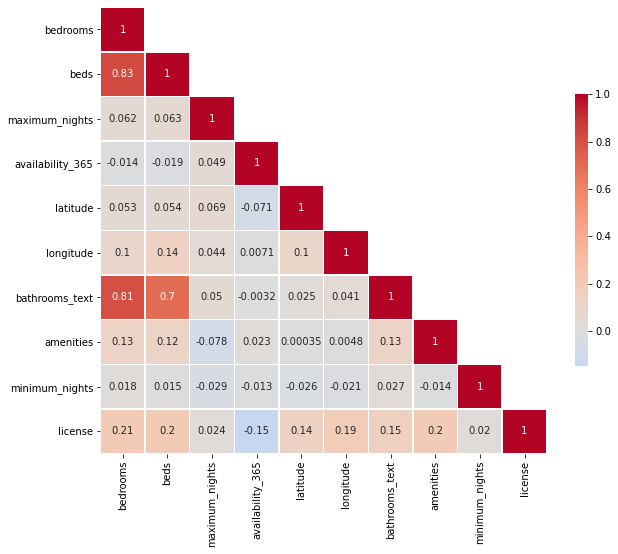

In [36]:
X_train_t2_corr = X_train_t2.iloc[:,0:10].corr()

mask = np.triu(np.ones_like(X_train_t2_corr,dtype=bool), k=1)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(X_train_t2_corr, mask=mask,cmap='coolwarm', vmax=1, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5}, ax=ax);

Como se aprecia en el gráfico de arriba, exceptuando 2 variables que están dentro del límite del valor que se ha
establecido, todas las demás parece ser que son totalmente independientes una de la otra.

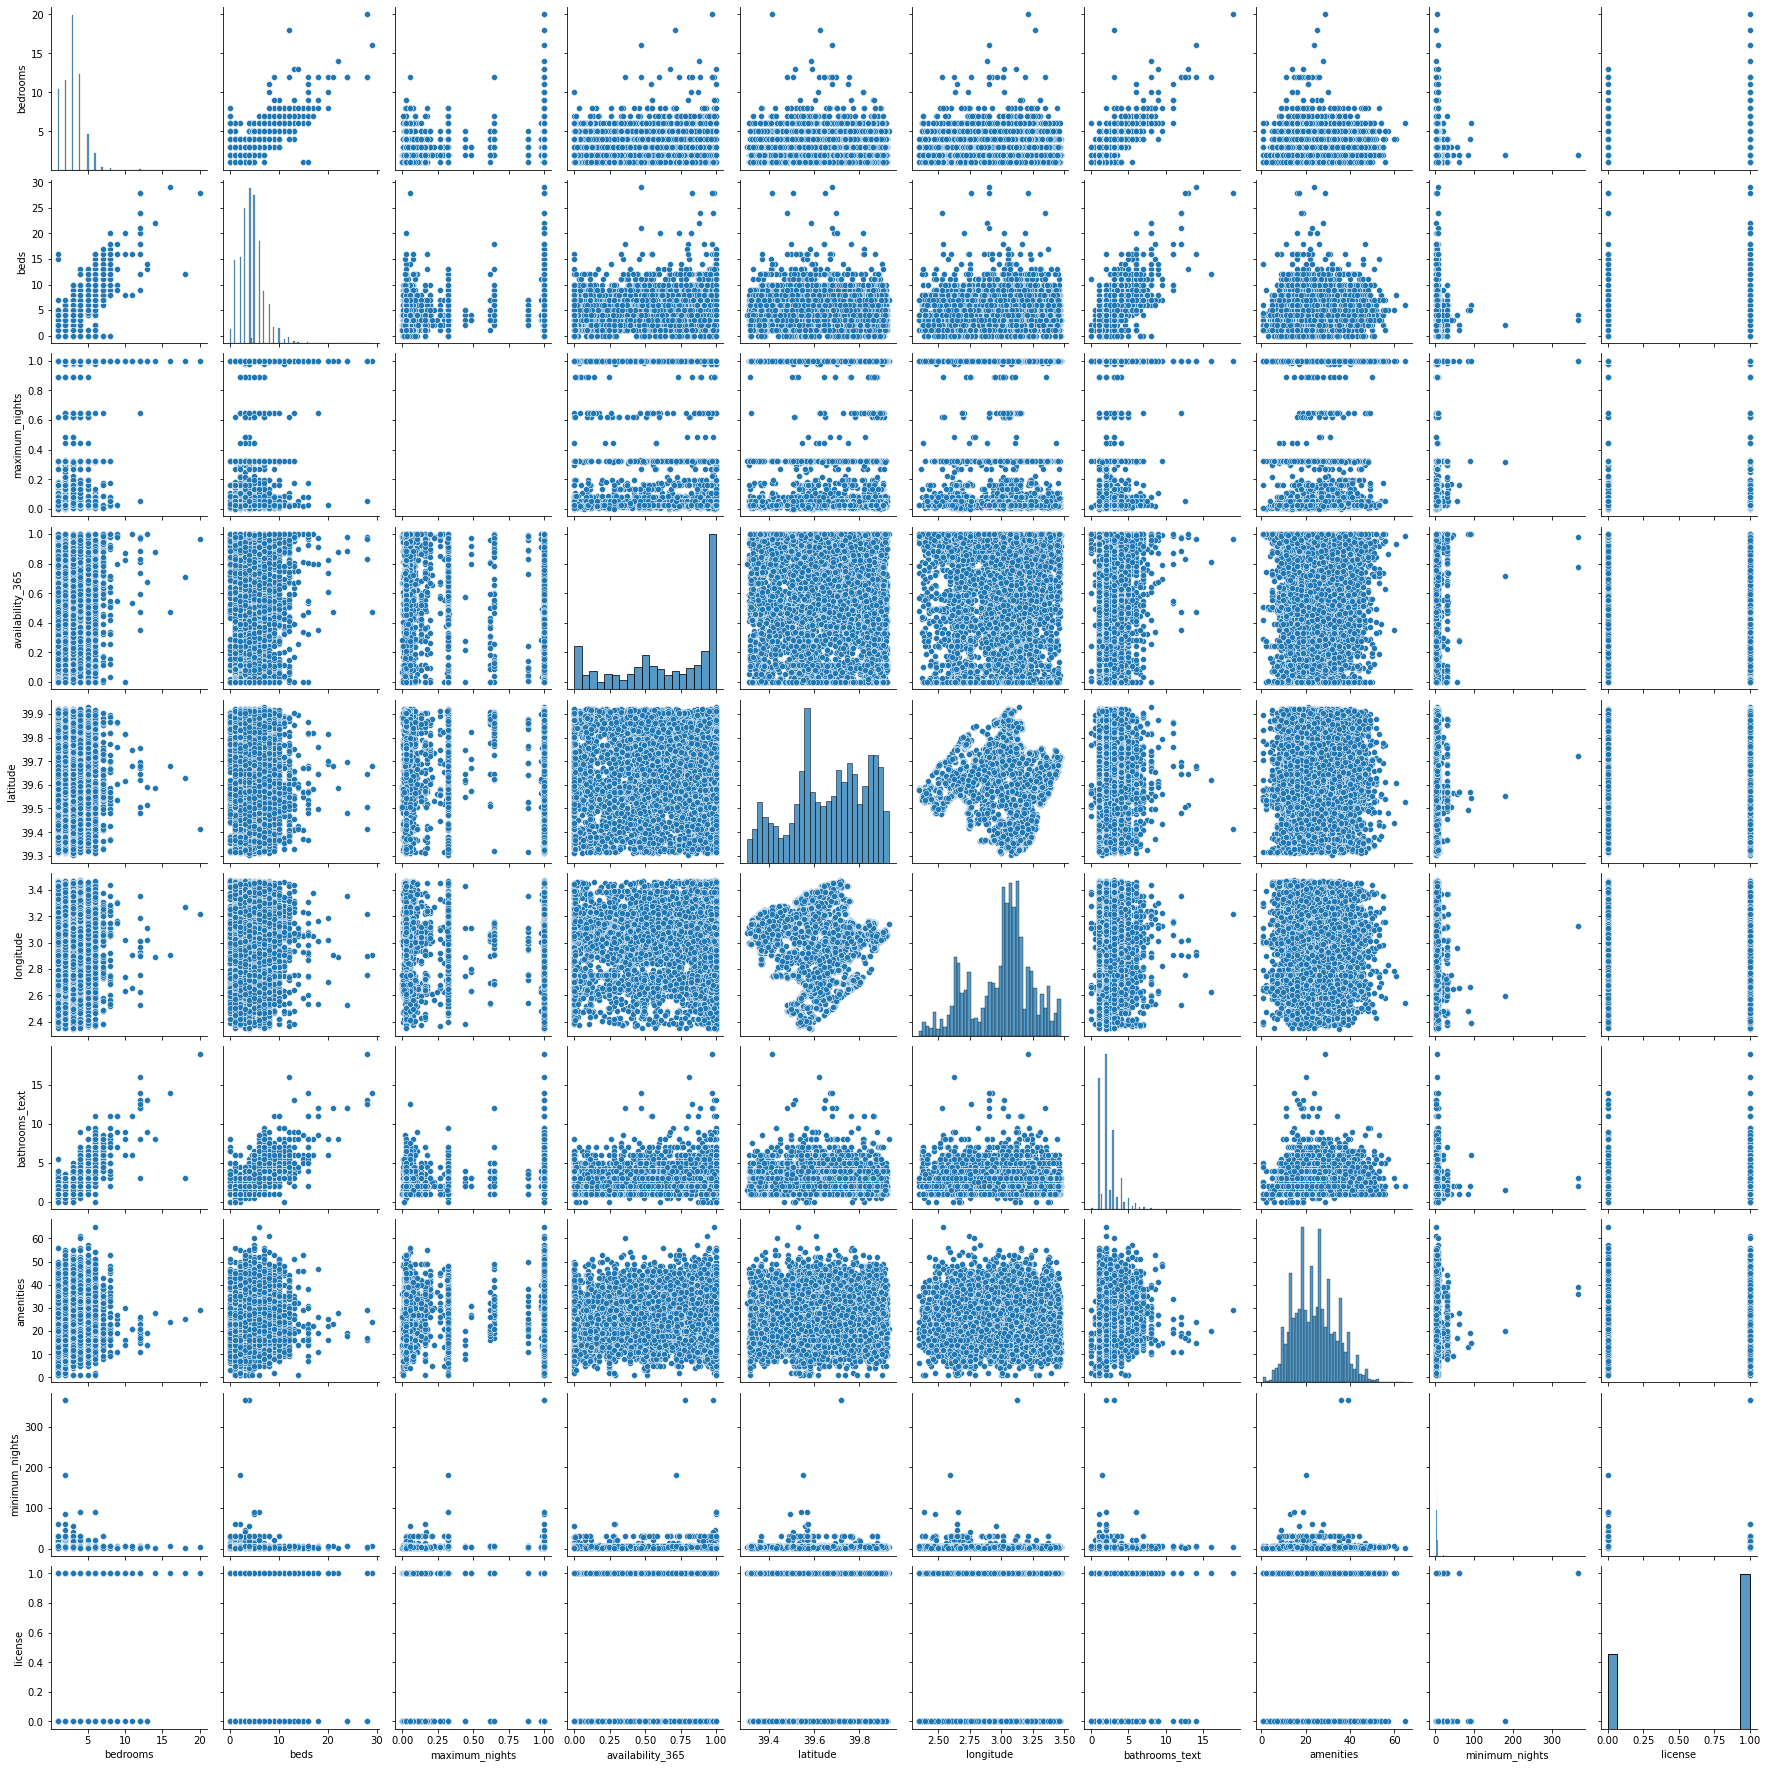

In [37]:
sns.pairplot(X_train_t2.iloc[:,0:10]);

Como se aprecia, el conjunto de datos es un poco caótico y es posible que los sistemas simples de regresión o de
clasificación no sean capaces de obtener buenos resultados, ya que los datos no dan sensación de tener estructura.

También se generará un dataset para calcular la correlación de estas mismas variables con la variable
que se quiere predecir.

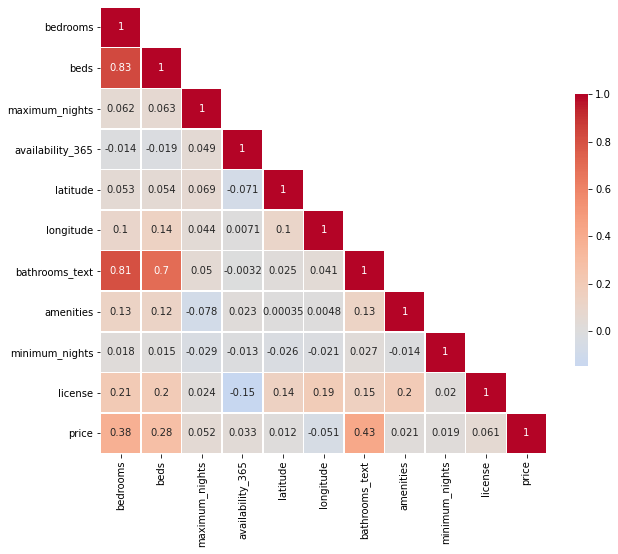

In [38]:
df_corr = X_train_t2.iloc[:,0:10]
df_corr = df_corr.assign(price=y_train_t2['price'])
df_corr_corr = df_corr.corr()
mask = np.triu(np.ones_like(df_corr_corr,dtype=bool), k=1)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_corr_corr, mask=mask,cmap='coolwarm', vmax=1, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5}, ax=ax);

Como se aprecia los datos no tienen una fuerte correlación con la variable que se quiere predecir,
esto puede ser un indicativo de que los datos no tienen una fuerte componente lineal con la variable
que se quiere predecir.

# Replicación en el conjunto de test y preparación del conjunto de validación

Una vez que ya se tiene el conjunto de entrenamiento transformado y adaptado, se deben adaptar 
el resto de conjuntos a partir de la información obtenida del conjunto de entrenamiento y 
aplicar los mismos transformadores pero solamente haciendo uso de la transformación.

Como se ha realizado en el conjunto de entrenamiento, se deben asignar manualmente
los nombres de las columnas, una vez aplicado el ```Pipeline```.

In [39]:
# Se aplica la transformación de escalado y de imputación de nulos y después se eliminan las variables
X_test_t = pd.DataFrame(full_pipe.transform(X_test))
X_test_t.columns = [*columnas_modificadas, *resto_columnas]
X_test_t2 = dhcc.transform(X_test_t) # Se eliminan las variables correlacionadas

In [40]:
X_test_t2.head()

bedrooms  beds  maximum_nights  availability_365  latitude  longitude  \
0       4.0   6.0             1.0          0.898630  39.43253    3.06953   
1       6.0  10.0             1.0          0.917808  39.70650    3.25164   
2       3.0   6.0             1.0          0.315068  39.65149    3.11455   
3       2.0   1.0             1.0          0.997260  39.69991    3.10364   
4       4.0   6.0             1.0          0.964384  39.43078    2.99933   

   bathrooms_text  amenities  minimum_nights  license  \
0             3.0       28.0             1.0      1.0   
1             7.0       21.0             7.0      1.0   
2             2.0       20.0             7.0      1.0   
3             2.0        9.0             1.0      0.0   
4             3.0       28.0             5.0      1.0   

   neighbourhood_cleansed_Alaró  neighbourhood_cleansed_Alcúdia  \
0                           0.0                             0.0   
1                           0.0                             0.0   
2                           0.0                             0.0   
3                           0.0                             0.0   
4                           0.0                             0.0   

   neighbourhood_cleansed_Algaida  neighbourhood_cleansed_Andratx  \
0                             0.0                             0.0   
1                             0.0                             0.0   
2                             0.0                             0.0   
3                             0.0                             0.0   
4                             0.0                             0.0   

   neighbourhood_cleansed_Ariany  neighbourhood_cleansed_Artà  \
0                            0.0                          0.0   
1                            0.0                          1.0   
2                            1.0                          0.0   
3                            0.0                          0.0   
4                            0.0                          0.0   

   neighbourhood_cleansed_Banyalbufar  neighbourhood_cleansed_Binissalem  \
0                                 0.0                                0.0   
1                                 0.0                                0.0   
2                                 0.0                                0.0   
3                                 0.0                                0.0   
4                                 0.0                                0.0   

   neighbourhood_cleansed_Bunyola  neighbourhood_cleansed_Búger  \
0                             0.0                           0.0   
1                             0.0                           0.0   
2                             0.0                           0.0   
3                             0.0                           0.0   
4                             0.0                           0.0   

   neighbourhood_cleansed_Calvià  neighbourhood_cleansed_Campanet  \
0                            0.0                              0.0   
1                            0.0                              0.0   
2                            0.0                              0.0   
3                            0.0                              0.0   
4                            0.0                              0.0   

   neighbourhood_cleansed_Campos  neighbourhood_cleansed_Capdepera  \
0                            1.0                               0.0   
1                            0.0                               0.0   
2                            0.0                               0.0   
3                            0.0                               0.0   
4                            1.0                               0.0   

   neighbourhood_cleansed_Consell  neighbourhood_cleansed_Costitx  \
0                             0.0                             0.0   
1                             0.0                             0.0   
2                             0.0                             0.0   
3                     

Se comprueba que no quede ninguna fila con valores nulos.

In [41]:
X_test_t2.iloc[:,0:10].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3171 entries, 0 to 3170
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bedrooms          3171 non-null   float64
 1   beds              3171 non-null   float64
 2   maximum_nights    3171 non-null   float64
 3   availability_365  3171 non-null   float64
 4   latitude          3171 non-null   float64
 5   longitude         3171 non-null   float64
 6   bathrooms_text    3171 non-null   float64
 7   amenities         3171 non-null   float64
 8   minimum_nights    3171 non-null   float64
 9   license           3171 non-null   float64
dtypes: float64(10)
memory usage: 247.9 KB


Una vez de que se dispone del conjunto de entrenamiento y del test transformado, hay que realizar el mismo
procedimiento con el conjunto de validación.
En este caso, hay que cargar el conjunto de validación y procesarlo.

In [42]:
df_validacion = pd.read_csv('../data/generated/pp_test_with_categorias.csv')
df_validacion = df_validacion.set_index('id')
df_validacion.head()
df_validacion2 = dc.transform(df_validacion)
X_validacion = dropPrice.fit_transform(df_validacion2)
y_validacion = selectPrice.fit_transform(df_validacion2)
# Se aplica la transformación de escalado y de imputación de nulos y después se eliminan las variables
X_validacion_t = pd.DataFrame(full_pipe.transform(X_validacion))
X_validacion_t.columns = [*columnas_modificadas, *resto_columnas]
# Se eliminan las variables correlacionadas
X_validacion_t2 = dhcc.transform(X_validacion_t)

Se comprueba que no quede ninguna fila con valores nulos.

In [43]:
X_validacion_t2.iloc[:,0:10].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3172 entries, 0 to 3171
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bedrooms          3172 non-null   float64
 1   beds              3172 non-null   float64
 2   maximum_nights    3172 non-null   float64
 3   availability_365  3172 non-null   float64
 4   latitude          3172 non-null   float64
 5   longitude         3172 non-null   float64
 6   bathrooms_text    3172 non-null   float64
 7   amenities         3172 non-null   float64
 8   minimum_nights    3172 non-null   float64
 9   license           3172 non-null   float64
dtypes: float64(10)
memory usage: 247.9 KB


Como algunas columnas se han transformado a coma flotante por haber ejecutado el ```Pipeline```,
estas se deben convertir, otra vez, a valor entero para generar los nuevos ficheros ```.csv``` con
los DataFrames transformados. Para ello, se seleccionan las columnas que son OHE y la columna
```amenities``` y se genera un diccionario que indicará las columnas que se deben convertir a entero.

In [44]:
column_names_to_int = X_test_t2.columns.values[8:]

In [45]:
as_int_dic = {'amenities': int}
for columna in column_names_to_int:
    as_int_dic[columna] = int

Una vez que se tienen transformados todos los conjuntos de datos, se deben juntar las columnas de
```X``` y de ```y``` para tener un único dataset para escribir los CSVs para el siguiente apartado del proyecto.

También se deben realizar algunas transformaciones en algunas variables para evitar problemas
de escritura de los valores en coma flotante.
En este caso, se ajustarán las siguientes variables para evitar tener este problema:

* bedrooms
* beds
* latitude
* longitude
* maximum_nights
* availability_365

In [46]:
X_train_t2 = X_train_t2.astype(as_int_dic)

In [47]:
X_train_t2_csv = X_train_t2.copy()

In [48]:
X_train_t2_csv['bedrooms'] = X_train_t2_csv['bedrooms'].map(lambda x: '%.1f' % x)
X_train_t2_csv['beds'] = X_train_t2_csv['beds'].map(lambda x: '%.1f' % x)
X_train_t2_csv['latitude'] = X_train_t2_csv['latitude'].map(lambda x: '%.5f' % x)
X_train_t2_csv['longitude'] = X_train_t2_csv['longitude'].map(lambda x: '%.5f' % x)
X_train_t2_csv['maximum_nights'] = X_train_t2_csv['maximum_nights'].map(lambda x: '%.7f' % x if x >0 and x<0.9999999999999999 else '%.1f' % x )
X_train_t2_csv['availability_365'] = X_train_t2_csv['availability_365'].map(lambda x: '%.7f' % x if x >0 and x<1 else '%.1f' % x)

In [49]:
X_test_t2 = X_test_t2.astype(as_int_dic)

In [50]:
X_test_t2_csv = X_test_t2.copy()

In [51]:
X_test_t2_csv['bedrooms'] = X_test_t2_csv['bedrooms'].map(lambda x: '%.1f' % x)
X_test_t2_csv['beds'] = X_test_t2_csv['beds'].map(lambda x: '%.1f' % x)
X_test_t2_csv['latitude'] = X_test_t2_csv['latitude'].map(lambda x: '%.5f' % x)
X_test_t2_csv['longitude'] = X_test_t2_csv['longitude'].map(lambda x: '%.5f' % x)
X_test_t2_csv['maximum_nights'] = X_test_t2_csv['maximum_nights'].map(lambda x: '%.7f' % x if x >0 and x<0.9999999999999999 else '%.1f' % x)
X_test_t2_csv['availability_365'] = X_test_t2_csv['availability_365'].map(lambda x: '%.7f' % x if x >0 and x<1 else '%.1f' % x)

In [52]:
X_validacion_t2 = X_validacion_t2.astype(as_int_dic)

In [53]:
X_validacion_t2_csv = X_validacion_t2.copy()

In [54]:
X_validacion_t2_csv['bedrooms'] = X_validacion_t2_csv['bedrooms'].map(lambda x: '%.1f' % x)
X_validacion_t2_csv['beds'] = X_validacion_t2_csv['beds'].map(lambda x: '%.1f' % x)
X_validacion_t2_csv['latitude'] = X_validacion_t2_csv['latitude'].map(lambda x: '%.5f' % x)
X_validacion_t2_csv['longitude'] = X_validacion_t2_csv['longitude'].map(lambda x: '%.5f' % x)
X_validacion_t2_csv['maximum_nights'] = X_validacion_t2_csv['maximum_nights'].map(lambda x: '%.7f' % x if x >0 and x<0.9999999999999999 else '%.1f' % x)
X_validacion_t2_csv['availability_365'] = X_validacion_t2_csv['availability_365'].map(lambda x: '%.7f' % x if x >0 and x<1 else '%.1f' % x)

Después de realizar la conversión, se comprueba visualmente que la transformación ha ido bien 
y se procede a escribir los DataFrames en ficheros.

In [55]:
X_validacion_t2_csv.head()

bedrooms beds maximum_nights availability_365  latitude longitude  \
0      2.0  2.0            1.0        0.9972603  39.52267   2.48893   
1      1.0  1.0            1.0              1.0  39.70052   3.10502   
2      6.0  7.0            1.0        0.5041096  39.76233   3.01405   
3      3.0  5.0            1.0        0.2547945  39.87430   3.05126   
4      5.0  0.0      0.3238434        0.7479452  39.36126   2.94969   

   bathrooms_text  amenities  minimum_nights  license  \
0             1.0         13               2        0   
1             2.0         13               1        0   
2             7.0         42               5        1   
3             1.0         13               7        1   
4             5.0         29               5        1   

   neighbourhood_cleansed_Alaró  neighbourhood_cleansed_Alcúdia  \
0                             0                               0   
1                             0                               0   
2                             0                               0   
3                             0                               0   
4                             0                               0   

   neighbourhood_cleansed_Algaida  neighbourhood_cleansed_Andratx  \
0                               0                               0   
1                               0                               0   
2                               0                               0   
3                               0                               0   
4                               0                               0   

   neighbourhood_cleansed_Ariany  neighbourhood_cleansed_Artà  \
0                              0                            0   
1                              0                            0   
2                              0                            0   
3                              0                            0   
4                              0                            0   

   neighbourhood_cleansed_Banyalbufar  neighbourhood_cleansed_Binissalem  \
0                                   0                                  0   
1                                   0                                  0   
2                                   0                                  0   
3                                   0                                  0   
4                                   0                                  0   

   neighbourhood_cleansed_Bunyola  neighbourhood_cleansed_Búger  \
0                               0                             0   
1                               0                             0   
2                               0                             0   
3                               0                             0   
4                               0                             0   

   neighbourhood_cleansed_Calvià  neighbourhood_cleansed_Campanet  \
0                              1                                0   
1                              0                                0   
2                              0                                0   
3                              0                                0   
4                              0                                0   

   neighbourhood_cleansed_Campos  neighbourhood_cleansed_Capdepera  \
0                              0                                 0   
1                              0                                 0   
2                              0                                 0   
3                              0                                 0   
4                              1                                 0   

   neighbourhood_cleansed_Consell  neighbourhood_cleansed_Costitx  \
0                               0                               0   
1                               0                               0   
2                               0                               0   
3                               0                  

In [56]:
df_tr_trans = X_train_t2_csv
df_tr_trans = df_tr_trans.assign(price=y_train_t2['price'])

In [57]:
df_te_trans = X_test_t2_csv
y_test_t2 = y_test.reset_index()
df_te_trans = df_te_trans.assign(price=y_test_t2['price'])

In [58]:
df_vl_trans = X_validacion_t2_csv
y_vl_t2 = y_validacion.reset_index()
df_vl_trans = df_vl_trans.assign(price=y_vl_t2['price'])

In [59]:
df_tr_trans.to_csv('../data/generated/tf_train.csv')
df_te_trans.to_csv('../data/generated/tf_test.csv')
df_vl_trans.to_csv('../data/generated/tf_validation.csv')